In [3]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt


class NeuralNetwork:

    def __init__(self, numInput, numHidden, numOutput, seed):
        self.ni = numInput
        self.nh = numHidden
        self.no = numOutput
        
        # These arrays will be updated through methods which are used in this class for building neural network #
        
        # Arrays for neural network nodes at different layers of the network 
        # (input_layer_nodes,hidden_layer_nodes,output_layer_nodes)
        self.iNodes = np.zeros(shape=[self.ni], dtype=np.float32)    # create an input nodes for input features as an array
        self.hNodes = np.zeros(shape=[self.nh], dtype=np.float32)    # create a hidden nodes for hidden layer as an array
        self.oNodes = np.zeros(shape=[self.no], dtype=np.float32)    # create an output nodes for target classes as an array
        ###########################

        # Arrays for neural network weights
        self.ihWeights = np.zeros(shape=[self.ni, self.nh], dtype=np.float32) # weights for nodes inputs(ni) to nodes hidden(nh)
        self.hoWeights = np.zeros(shape=[self.nh, self.no], dtype=np.float32) # weights for nodes hidden (nh) to nodes output(no)
        ###########################
        
        # Arrays for neural network weights biases
        self.hBiases = np.zeros(shape=[self.nh], dtype=np.float32) # Biases for nodes in Hidden Layer
        self.oBiases = np.zeros(shape=[self.no], dtype=np.float32) # # Biases for nodes in output Layer
        ###########################
        
        # Arrays for neural network weights gradients
        self.hoGrads = np.zeros(shape=[self.nh, self.no], dtype=np.float32)  # hidden-to-output weights gradients
        self.ihGrads = np.zeros(shape=[self.ni, self.nh], dtype=np.float32)  # input-to-hidden weights gradients
        ###########################
        
        # Arrays for neural network biases gradients
        self.hbGrads = np.zeros(shape=[self.nh], dtype=np.float32)  # hidden biases gradients
        self.obGrads = np.zeros(shape=[self.no], dtype=np.float32)  # output node biases gradients
        ###########################
        
        # Arrays for neural network signals
        self.oSignals = np.zeros(shape=[self.no], dtype=np.float32)  # output signals: gradients w/o assoc. input terms
        self.hSignals = np.zeros(shape=[self.nh], dtype=np.float32)  # hidden signals: gradients w/o assoc. input terms
        ########################### 
        
        # Arrays for weights delta
        self.ih_prev_weights_delta = np.zeros(shape=[self.ni, self.nh], dtype=np.float32)
        self.ho_prev_weights_delta = np.zeros(shape=[self.nh, self.no], dtype=np.float32)# 
        ###########################
        
        # Arrays for biases delta
        self.h_prev_biases_delta = np.zeros(shape=[self.nh], dtype=np.float32)
        self.o_prev_biases_delta = np.zeros(shape=[self.no], dtype=np.float32)
        ###########################
        
        self.x_values = np.zeros(shape=[self.ni], dtype=np.float32) # input values --> features
        self.t_values = np.zeros(shape=[self.no], dtype=np.float32) # output values --> target (classes)
        self.tw = (self.ni * self.nh) + (self.nh* self.no) + self.nh+ self.no
        self.rnd = random.Random(seed)  # allows multiple instances
        self.initializeWeights()

    def Update_Weights(self):
        result = np.zeros(shape=[self.tw], dtype=np.float32)

        idx = 0  # points into result

        for i in range(self.ni):
            for j in range(self.nh):
                result[idx] = self.ihWeights[i, j]
                idx += 1

        for j in range(self.nh):
            result[idx] = self.hBiases[j]
            idx += 1

        for i in range(self.nh):
            for k in range(self.no):
                result[idx] = self.hoWeights[i, k]
                idx += 1

        for k in range(self.no):
            result[idx] = self.oBiases[k]
            idx += 1

        return result

    def initializeWeights(self):
        wts = np.zeros(shape=[self.tw], dtype=np.float32)
        lo = -0.01;
        hi = 0.01
        for idx in range(len(wts)):
            wts[idx] = (hi - lo) * self.rnd.random() + lo

        if len(wts) != self.tw:
            print("Warning: len(weights) error in Weights()")

        idx = 0
        for i in range(self.ni):
            for j in range(self.nh):
                self.ihWeights[i, j] = wts[idx]
                idx += 1

        for j in range(self.nh):
            self.hBiases[j] = wts[idx]
            idx += 1

        for i in range(self.nh):
            for j in range(self.no):
                self.hoWeights[i, j] = wts[idx]
                idx += 1

        for k in range(self.no):
            self.oBiases[k] = wts[idx]
            idx += 1


    def forward_propagation(self, xValues):
        hSums = np.zeros(shape=[self.nh], dtype=np.float32)
        oSums = np.zeros(shape=[self.no], dtype=np.float32)

        for i in range(self.ni):
            self.iNodes[i] = xValues[i]
        for j in range(self.nh):
            for i in range(self.ni):
                hSums[j] += self.iNodes[i] * self.ihWeights[i, j]

        for j in range(self.nh):
            hSums[j] += self.hBiases[j]


        for j in range(self.nh):
            self.hNodes[j] = self.activation_func_hypertan(hSums[j])


        for k in range(self.no):
            for j in range(self.nh):
                oSums[k] += self.hNodes[j] * self.hoWeights[j, k]


        for k in range(self.no):
            oSums[k] += self.oBiases[k]

        softOut = self.activation_func_softmax(oSums)

        for k in range(self.no):
            self.oNodes[k] = softOut[k]
        result = np.zeros(shape=self.no, dtype=np.float32)
        for k in range(self.no):
            result[k] = self.oNodes[k]
        return result
    def back_propagation(self,learnRate, momentum):
        for k in range(self.no):
            derivative = (1 - self.oNodes[k]) * self.oNodes[k]  # softmax
            self.oSignals[k] = derivative * (self.t_values[k] - self.oNodes[k])  # target - output => add delta

        # 2. compute hidden-to-output weight gradients using output signals
        for j in range(self.nh):
            for k in range(self.no):
                self.hoGrads[j, k] = self.oSignals[k] * self.hNodes[j]

        # 3. compute output node bias gradients using output signals
        for k in range(self.no):
            self.obGrads[k] = self.oSignals[k] * 1.0  # 1.0 dummy input can be dropped

        # 4. compute hidden node signals
        for j in range(self.nh):
            sum = 0.0
            for k in range(self.no):
                sum += self.oSignals[k] * self.hoWeights[j, k]
            derivative = (1 - self.hNodes[j]) * (1 + self.hNodes[j])  # tanh activation
            self.hSignals[j] = derivative * sum

        # 5 compute input-to-hidden weight gradients using hidden signals
        for i in range(self.ni):
            for j in range(self.nh):
                self.ihGrads[i, j] = self.hSignals[j] * self.iNodes[i]

        # 6. compute hidden node bias gradients using hidden signals
        for j in range(self.nh):
            self.hbGrads[j] = self.hSignals[j] * 1.0  # 1.0 dummy input can be dropped

        # update weights and biases using the gradients

        # 1. update input-to-hidden weights
        for i in range(self.ni):
            for j in range(self.nh):
                delta = learnRate * self.ihGrads[i, j]
                self.ihWeights[i, j] += delta
                self.ihWeights[i, j] += momentum * self.ih_prev_weights_delta[i, j]
                self.ih_prev_weights_delta[i, j] = delta  # save the delta for next iteration

        # 2. update hidden node biases
        for j in range(self.nh):
            delta = learnRate * self.hbGrads[j] * 1.0  # can drop the dummy 1.0 input
            self.hBiases[j] += delta
            self.hBiases[j] += momentum * self.h_prev_biases_delta[j]
            self.h_prev_biases_delta[j] = delta  # save the delta

        # 3. update hidden-to-output weights
        for j in range(self.nh):
            for k in range(self.no):
                delta = learnRate * self.hoGrads[j, k]
                self.hoWeights[j, k] += delta
                self.hoWeights[j, k] += momentum * self.ho_prev_weights_delta[j, k]
                self.ho_prev_weights_delta[j, k] = delta  # save the delta

        # 4. update output node biases
        for k in range(self.no):
            delta = learnRate * self.obGrads[k]
            self.oBiases[k] += delta
            self.oBiases[k] += momentum * self.o_prev_biases_delta[k]
            self.o_prev_biases_delta[k] = delta  # save the delta

    def train(self, trainData, maxEpochs, learnRate, momentum):
        epoch = 0
        errors = []
        accs = []
        # x_values = np.zeros(shape=[self.ni], dtype=np.float32)
        # t_values = np.zeros(shape=[self.no], dtype=np.float32)
        numTrainItems = len(trainData)
        indices = np.arange(numTrainItems)  # [0, 1, 2, . . n-1]  # rnd.shuffle(v)

        while epoch < maxEpochs:
            self.rnd.shuffle(indices)  # scramble order of training items
            for ii in range(numTrainItems):
                idx = indices[ii]

                for j in range(self.ni):
                    self.x_values[j] = trainData[idx, j]  # get the input values
                for j in range(self.no):
                    self.t_values[j] = trainData[idx, j + self.ni]  # get the target values
                self.forward_propagation(self.x_values)  # results stored internally
                self.back_propagation(learnRate, momentum)

            epoch += 1

            if epoch % 100 == 0:
                mse = self.meanSquaredError(trainData)
                accu= self.accuracy(trainData)
                print("epoch = " + str(epoch) + " ms error = %0.4f " % mse)
                print("epoch = " + str(epoch) + " ms accu = %0.4f " % (1-mse))

                errors.append(mse)
                accs.append((1-mse))
        # end while
        result = self.Update_Weights()
        return result,accs,errors

    # end train

    def accuracy(self, tdata):  # train or test data matrix
        num_correct = 0;
        num_wrong = 0
        # x_values = np.zeros(shape=[self.ni], dtype=np.float32)
        # t_values = np.zeros(shape=[self.no], dtype=np.float32)

        for i in range(len(tdata)):  # walk thru each data item
            for j in range(self.ni):  # peel off input values from curr data row
                self.x_values[j] = tdata[i, j]
            for j in range(self.no):  # peel off tareget values from curr data row
                self.t_values[j] = tdata[i, j + self.ni]

            y_values = self.forward_propagation(self.x_values)  # computed output values)
            max_index = np.argmax(y_values)  # index of largest output value

            if abs(self.t_values[max_index] - 1.0) < 1.0e-5:
                num_correct += 1
            else:
                num_wrong += 1

        return (num_correct * 1.0) / (num_correct + num_wrong)

    def meanSquaredError(self, tdata):  # on train or test data matrix
        sumSquaredError = 0.0
        # x_values = np.zeros(shape=[self.ni], dtype=np.float32)
        # t_values = np.zeros(shape=[self.no], dtype=np.float32)

        for i in range(len(tdata)):  # walk through each data item
            for j in range(self.ni):  # peel off input values from curr data row
                self.x_values[j] = tdata[i, j]

            for j in range(self.no):  # peel off tareget values from curr data row
                self.t_values[j] = tdata[i, j + self.ni]

            y_values = self.forward_propagation(self.x_values)  # computed output values

            for j in range(self.no):
                err = self.t_values[j] - y_values[j]
                sumSquaredError += err * err
        return sumSquaredError / len(tdata)

    @staticmethod
    def activation_func_hypertan(x):
        if x < -20.0:
            return -1.0
        elif x > 20.0:
            return 1.0
        else:
            return math.tanh(x)

    @staticmethod
    def activation_func_softmax(oSums):
        result = np.zeros(shape=[len(oSums)], dtype=np.float32)
        m = max(oSums)
        divisor = 0.0
        for k in range(len(oSums)):
            divisor += math.exp(oSums[k] - m)
        for k in range(len(result)):
            result[k] = math.exp(oSums[k] - m) / divisor
        return result


# end class NeuralNetwork


epoch = 100 ms error = 0.5678 
epoch = 100 ms accu = 0.4322 
epoch = 200 ms error = 0.5374 
epoch = 200 ms accu = 0.4626 
epoch = 300 ms error = 0.5505 
epoch = 300 ms accu = 0.4495 
epoch = 400 ms error = 0.5997 
epoch = 400 ms accu = 0.4003 
epoch = 500 ms error = 0.5608 
epoch = 500 ms accu = 0.4392 
Training complete without momentum
accuracy without momentum

Accuracy on 742-item train data = 0.5391 
Accuracy on 248-item test data   = 0.4315 


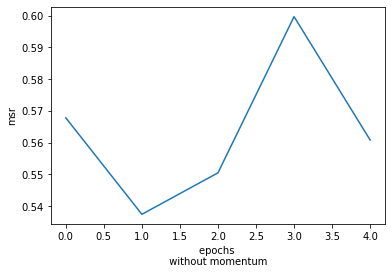

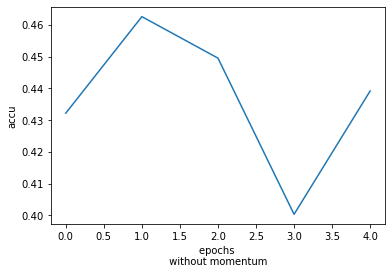

In [4]:

numInput = 12
numHidden = 6
numOutput = 11
seed = 3
nn = NeuralNetwork(numInput, numHidden, numOutput, seed)
trainDataPath = "vowel_train.txt"
trainDataMatrix = np.loadtxt(trainDataPath, dtype=np.float32, delimiter=",")  
testDataPath = "vowel_test.txt"
testDataMatrix = np.loadtxt(testDataPath, dtype=np.float32, delimiter=",")  
maxEpochs = 500
learnRate = 0.1
result,accu,errors=nn.train(trainDataMatrix, maxEpochs, learnRate, 0.0)
print("Training complete without momentum")  
print("accuracy without momentum")
accTrain = nn.accuracy(trainDataMatrix)
accTest = nn.accuracy(testDataMatrix)
print("\nAccuracy on 742-item train data = %0.4f " % accTrain)
print("Accuracy on 248-item test data   = %0.4f " % accTest)

epochs = [0, 1, 2, 3, 4]
plt.plot(epochs, errors)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('msr')
plt.show()
plt.plot(epochs, accu)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('accu')
plt.show() 


epoch = 100 ms error = 0.5828 
epoch = 100 ms accu = 0.4172 
epoch = 200 ms error = 0.5075 
epoch = 200 ms accu = 0.4925 
epoch = 300 ms error = 0.4844 
epoch = 300 ms accu = 0.5156 
epoch = 400 ms error = 0.4910 
epoch = 400 ms accu = 0.5090 
epoch = 500 ms error = 0.4918 
epoch = 500 ms accu = 0.5082 
Training complete without momentum

Accuracy on 742-item train data = 0.5889 
Accuracy on 248-item test data   = 0.4032 


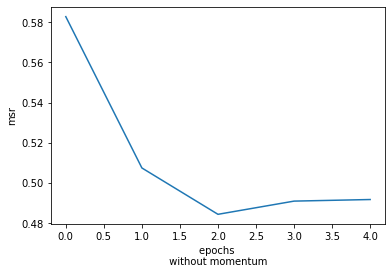

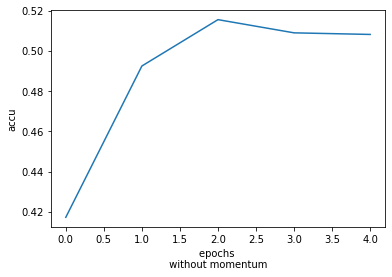

In [5]:
learnRate = 0.05
result,accu,errors=nn.train(trainDataMatrix, maxEpochs, learnRate, 0.0)
print("Training complete without momentum")  

accTrain = nn.accuracy(trainDataMatrix)
accTest = nn.accuracy(testDataMatrix)
  
print("\nAccuracy on 742-item train data = %0.4f " % accTrain)
print("Accuracy on 248-item test data   = %0.4f " % accTest)


plt.plot(epochs, errors)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('msr')
plt.show()
plt.plot(epochs, accu)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('accu')
plt.show() 

epoch = 100 ms error = 0.4434 
epoch = 100 ms accu = 0.5566 
epoch = 200 ms error = 0.4387 
epoch = 200 ms accu = 0.5613 
epoch = 300 ms error = 0.4373 
epoch = 300 ms accu = 0.5627 
epoch = 400 ms error = 0.4361 
epoch = 400 ms accu = 0.5639 
epoch = 500 ms error = 0.4339 
epoch = 500 ms accu = 0.5661 
Training complete without momentum

Accuracy on 742-item train data = 0.6442 
Accuracy on 248-item test data   = 0.4274 


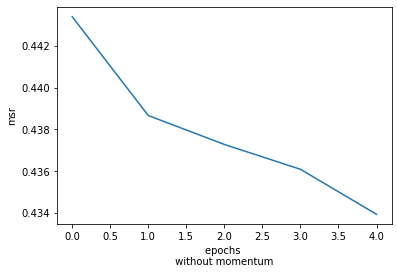

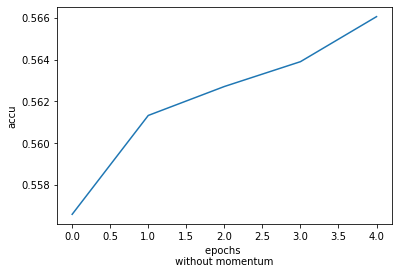

In [6]:
learnRate = 0.01
result,accu,errors=nn.train(trainDataMatrix, maxEpochs, learnRate, 0.0)
print("Training complete without momentum")  

accTrain = nn.accuracy(trainDataMatrix)
accTest = nn.accuracy(testDataMatrix)
  
print("\nAccuracy on 742-item train data = %0.4f " % accTrain)
print("Accuracy on 248-item test data   = %0.4f " % accTest)

plt.plot(epochs, errors)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('msr')
plt.show()
plt.plot(epochs, accu)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('accu')
plt.show() 

In [ ]:
learnRate = 0.001
result,accu,errors=nn.train(trainDataMatrix, maxEpochs, learnRate, 0.0)
print("Training complete without momentum")  

accTrain = nn.accuracy(trainDataMatrix)
accTest = nn.accuracy(testDataMatrix)
  
print("\nAccuracy on 742-item train data = %0.4f " % accTrain)
print("Accuracy on 248-item test data   = %0.4f " % accTest)


plt.plot(epochs, errors)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('msr')
plt.show()
plt.plot(epochs, accu)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('accu')
plt.show() 

epoch = 100 ms error = 0.8071 
epoch = 100 ms accu = 0.1929 
epoch = 200 ms error = 0.7891 
epoch = 200 ms accu = 0.2109 
epoch = 300 ms error = 0.7785 
epoch = 300 ms accu = 0.2215 
epoch = 400 ms error = 0.7732 
epoch = 400 ms accu = 0.2268 
epoch = 500 ms error = 0.7710 
epoch = 500 ms accu = 0.2290 
Training complete without momentum

Accuracy on 742-item train data = 0.3167 
Accuracy on 248-item test data   = 0.2298 


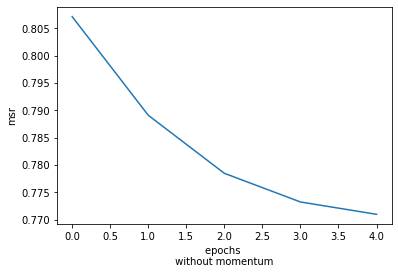

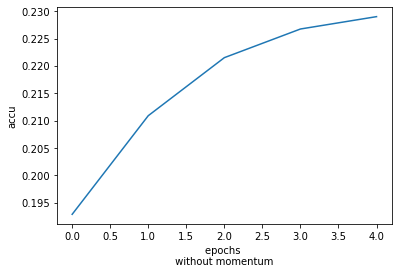

In [7]:

numHidden = 1

seed = 3
nn = NeuralNetwork(numInput, numHidden, numOutput, seed)
learnRate = 0.01  # the best learning rate from above trials
result,accu,errors=nn.train(trainDataMatrix, maxEpochs, learnRate, 0.0)
print("Training complete without momentum")  
accTrain = nn.accuracy(trainDataMatrix)
accTest = nn.accuracy(testDataMatrix)
  
print("\nAccuracy on 742-item train data = %0.4f " % accTrain)
print("Accuracy on 248-item test data   = %0.4f " % accTest)

plt.plot(epochs, errors)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('msr')
plt.show()
plt.plot(epochs, accu)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('accu')
plt.show() 

epoch = 100 ms error = 0.7475 
epoch = 100 ms accu = 0.2525 
epoch = 200 ms error = 0.6975 
epoch = 200 ms accu = 0.3025 
epoch = 300 ms error = 0.6781 
epoch = 300 ms accu = 0.3219 
epoch = 400 ms error = 0.6742 
epoch = 400 ms accu = 0.3258 
epoch = 500 ms error = 0.6995 
epoch = 500 ms accu = 0.3005 
Training complete without momentum

Accuracy on 105-item train data = 0.3868 
Accuracy on 45-item test data   = 0.2903 


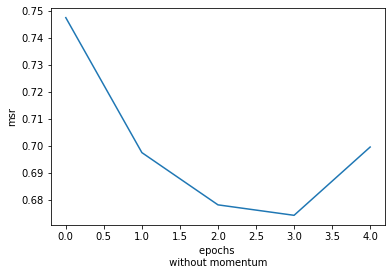

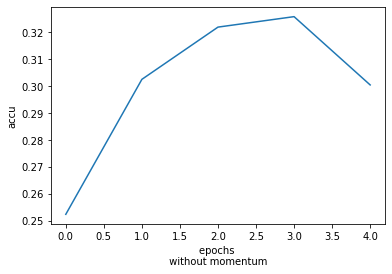

In [8]:

numHidden = 2
seed = 3
nn = NeuralNetwork(numInput, numHidden, numOutput, seed)
result,accu,errors=nn.train(trainDataMatrix, maxEpochs, learnRate, 0.0)
print("Training complete without momentum")  

accTrain = nn.accuracy(trainDataMatrix)
accTest = nn.accuracy(testDataMatrix)
  
print("\nAccuracy on 105-item train data = %0.4f " % accTrain)
print("Accuracy on 45-item test data   = %0.4f " % accTest)

plt.plot(epochs, errors)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('msr')
plt.show()
plt.plot(epochs, accu)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('accu')
plt.show()

In [ ]:

numHidden = 3
seed = 3
nn = NeuralNetwork(numInput, numHidden, numOutput, seed)
result,accu,errors=nn.train(trainDataMatrix, maxEpochs, learnRate, 0.0)
print("Training complete without momentum")  

accTrain = nn.accuracy(trainDataMatrix)
accTest = nn.accuracy(testDataMatrix)
  
print("\nAccuracy on 105-item train data = %0.4f " % accTrain)
print("Accuracy on 45-item test data   = %0.4f " % accTest)

plt.plot(epochs, errors)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('msr')
plt.show()
plt.plot(epochs, accu)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('accu')
plt.show()

epoch = 100 ms error = 0.5759 
epoch = 100 ms accu = 0.4241 
epoch = 200 ms error = 0.4510 
epoch = 200 ms accu = 0.5490 
epoch = 300 ms error = 0.4321 
epoch = 300 ms accu = 0.5679 
epoch = 400 ms error = 0.4822 
epoch = 400 ms accu = 0.5178 
epoch = 500 ms error = 0.4835 
epoch = 500 ms accu = 0.5165 
Training complete without momentum

Accuracy on 105-item train data = 0.6523 
Accuracy on 45-item test data   = 0.5161 


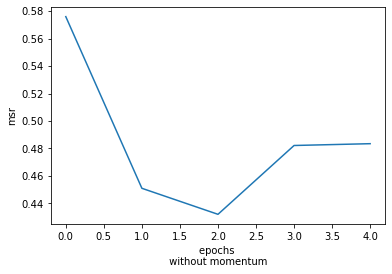

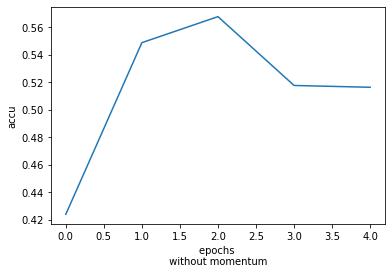

In [9]:

numHidden = 4
seed = 3
nn = NeuralNetwork(numInput, numHidden, numOutput, seed)
result,accu,errors=nn.train(trainDataMatrix, maxEpochs, learnRate, 0.0)
print("Training complete without momentum")  

accTrain = nn.accuracy(trainDataMatrix)
accTest = nn.accuracy(testDataMatrix)
  
print("\nAccuracy on 105-item train data = %0.4f " % accTrain)
print("Accuracy on 45-item test data   = %0.4f " % accTest)

plt.plot(epochs, errors)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('msr')
plt.show()
plt.plot(epochs, accu)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('accu')
plt.show()

In [ ]:

numHidden = 5
seed = 3
nn = NeuralNetwork(numInput, numHidden, numOutput, seed)
result,accu,errors=nn.train(trainDataMatrix, maxEpochs, learnRate, 0.0)
print("Training complete without momentum")  

accTrain = nn.accuracy(trainDataMatrix)
accTest = nn.accuracy(testDataMatrix)
  
print("\nAccuracy on 105-item train data = %0.4f " % accTrain)
print("Accuracy on 45-item test data   = %0.4f " % accTest)

plt.plot(epochs, errors)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('msr')
plt.show()
plt.plot(epochs, accu)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('accu')
plt.show()

epoch = 100 ms error = 0.5552 
epoch = 100 ms accu = 0.4448 
epoch = 200 ms error = 0.4047 
epoch = 200 ms accu = 0.5953 
epoch = 300 ms error = 0.3599 
epoch = 300 ms accu = 0.6401 
epoch = 400 ms error = 0.4142 
epoch = 400 ms accu = 0.5858 
epoch = 500 ms error = 0.3533 
epoch = 500 ms accu = 0.6467 
Training complete without momentum

Accuracy on 105-item train data = 0.7480 
Accuracy on 45-item test data   = 0.6331 


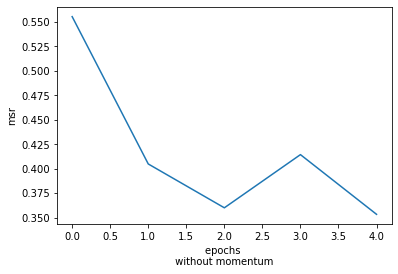

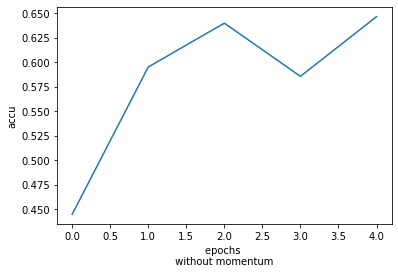

In [10]:

numHidden = 6
seed = 3
nn = NeuralNetwork(numInput, numHidden, numOutput, seed)
result,accu,errors=nn.train(trainDataMatrix, maxEpochs, learnRate, 0.0)
print("Training complete without momentum")  

accTrain = nn.accuracy(trainDataMatrix)
accTest = nn.accuracy(testDataMatrix)
  
print("\nAccuracy on 105-item train data = %0.4f " % accTrain)
print("Accuracy on 45-item test data   = %0.4f " % accTest)

plt.plot(epochs, errors)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('msr')
plt.show()
plt.plot(epochs, accu)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('accu')
plt.show()

epoch = 100 ms error = 0.4891 
epoch = 100 ms accu = 0.5109 
epoch = 200 ms error = 0.3542 
epoch = 200 ms accu = 0.6458 
epoch = 300 ms error = 0.2937 
epoch = 300 ms accu = 0.7063 
epoch = 400 ms error = 0.2636 
epoch = 400 ms accu = 0.7364 
epoch = 500 ms error = 0.2664 
epoch = 500 ms accu = 0.7336 
Training complete without momentum

Accuracy on 105-item train data = 0.8275 
Accuracy on 45-item test data   = 0.6734 


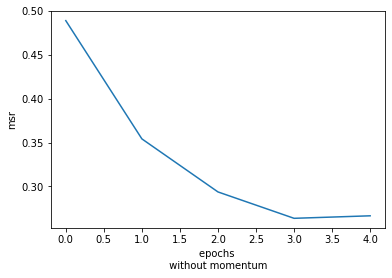

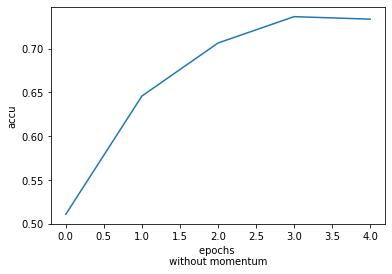

In [11]:

numHidden = 10
seed = 3
nn = NeuralNetwork(numInput, numHidden, numOutput, seed)
result,accu,errors=nn.train(trainDataMatrix, maxEpochs, learnRate, 0.0)
print("Training complete without momentum")  

accTrain = nn.accuracy(trainDataMatrix)
accTest = nn.accuracy(testDataMatrix)
  
print("\nAccuracy on 105-item train data = %0.4f " % accTrain)
print("Accuracy on 45-item test data   = %0.4f " % accTest)

plt.plot(epochs, errors)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('msr')
plt.show()
plt.plot(epochs, accu)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('accu')
plt.show()

epoch = 100 ms error = 0.4757 
epoch = 100 ms accu = 0.5243 
epoch = 200 ms error = 0.3073 
epoch = 200 ms accu = 0.6927 
epoch = 300 ms error = 0.2251 
epoch = 300 ms accu = 0.7749 
epoch = 400 ms error = 0.1838 
epoch = 400 ms accu = 0.8162 
epoch = 500 ms error = 0.1629 
epoch = 500 ms accu = 0.8371 
Training complete without momentum

Accuracy on 105-item train data = 0.9178 
Accuracy on 45-item test data   = 0.7258 


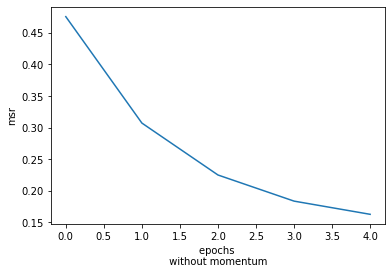

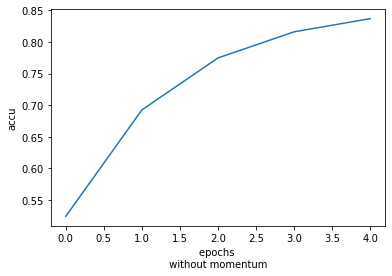

In [12]:

numHidden = 15
seed = 3
nn = NeuralNetwork(numInput, numHidden, numOutput, seed)
result,accu,errors=nn.train(trainDataMatrix, maxEpochs, learnRate, 0.0)
print("Training complete without momentum")  

accTrain = nn.accuracy(trainDataMatrix)
accTest = nn.accuracy(testDataMatrix)
  
print("\nAccuracy on 105-item train data = %0.4f " % accTrain)
print("Accuracy on 45-item test data   = %0.4f " % accTest)

plt.plot(epochs, errors)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('msr')
plt.show()
plt.plot(epochs, accu)
plt.xlabel("epochs \n without momentum ")
plt.ylabel('accu')
plt.show()

In [ ]:
# the best learning rate for vowel data is 0.01
# the best number for hidden layers for vowel data is 15